# Introduction to PyTorch

PyTorch is a popular deep learning framework that was introduced in 2016. It has a slightly lower-level API than Keras, but it is very easy to use when it comes to defining models with custom loss functions or exotic architectures with a structure that depends on the input data (e.g. for NLP). It is very popular among researchers and kagglers - a little less in the industry (yet) compared to TensorFlow / Keras.

http://pytorch.org/

## Principles

PyTorch essentially provides the user with two main utilities:

- It allows to perform Tensor/vector computation on the GPU with an API similar (but still not 100% compatible) to Numpy.

- It records all computation to be able to backpropagate through them. That is, provided a sequence of operations that starts from a tensor $\theta$ to define a scalar $g(\theta)$, it is able to compute 
$\nabla_\theta g(\theta)$ exactly, with only one function call.

Typically, $\theta$ will be a parameter of a neural network and $g$ a loss function such as $\ell(f_{\theta}(x), y)$ for supervised learning. 

In PyTorch, every node in the computation graph is defined on the fly while executing the forward pass, from within the Python interpreter: any NumPy code can be ported to PyTorch easily, and all flow control operation (e.g. loops, if/else, etc.) can be kept untouched.

PyTorch takes care of recording everything it needs to do the backpropagation, *on the fly*.

Note that recent versions of TensorFlow (2.0 and later) now come with [eager execution](https://www.tensorflow.org/guide/eager) enabled by default to make TensorFlow use the define-by-run semantics of PyTorch (and Chainer).

## Installation

You can check the version number of the currently installed pytorch package with: `import torch; print(torch.__version__)`.

If you do not have a CUDA-based GPU on your machine please feel free to use the CPU-only version as those introductory notebooks do not require a GPU.

Up-to-date installation instructions (including pip-based installation instructions) can be found on the official home page of the project: http://pytorch.org.

If pytorch version is too old and was previously installed from another conda channel, conda upgrade might not work. You need to `conda remove pytorch` first and then reinstall it.

## Setting up the device
PyTorch can run on either CPU or GPU. The new API (v0.4.0) lets us define it in a nice way 

In [2]:
import torch

# Two options: 'cuda' (for GPU) or 'cpu' (if no GPU available)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

print("Device type set:", "GPU" if device.type == "cuda" else "CPU")

Device type set: CPU


## A first example

We will define a vector $x \in \mathbb{R}^n$ and computes its norms using PyTorch. For this, we will define our first `Tensor` -- the Tensor object is the central element of PyTorch. It is very similar to a numpy array.

Let us fill this vector with random values:

In [3]:
torch.manual_seed(42)

n = 3
x = torch.rand(n, dtype=torch.float32)

`x` is a tensor, which can be manipulated roughly as a Numpy array:

In [4]:
x

tensor([0.8823, 0.9150, 0.3829])

Let's do a small API tour

In [5]:
x.shape

torch.Size([3])

In [6]:
x.shape[0]

3

In [7]:
x * 10

tensor([8.8227, 9.1500, 3.8286])

We can go back and forth from numpy to PyTorch tensors:

In [8]:
x_np = x.numpy()

In [9]:
import numpy as np

A = torch.from_numpy(np.ones((n, n)))

A

tensor([[1., 1., 1.],
        [1., 1., 1.],
        [1., 1., 1.]], dtype=torch.float64)

Note that all tensors are typed and that you can only do operations with tensors of the same type. Mixing tensor types will lead to a runtime error:

In [10]:
try:
    torch.matmul(A, x)
except RuntimeError as e:
    print(e)

expected scalar type Double but found Float


Explicit type conversion are required. Note while numpy uses the `dtype` attribute to store the type of the data items, this information is part of the type of the Tensor itself in PyTorch.

In [11]:
A.float()

tensor([[1., 1., 1.],
        [1., 1., 1.],
        [1., 1., 1.]])

In [12]:
torch.matmul(A.float(), x)

tensor([2.1801, 2.1801, 2.1801])

In Python 3.5 and later it's possible to use the `@` operator syntax for matrix-matrix or matrix-vector multiplication operations:

In [13]:
A.float() @ x

tensor([2.1801, 2.1801, 2.1801])

Let us now define a norm function that returns the euclidean norm of a vector $x \in \mathbb{R}^n$:

$$f(x) = || x ||_2$$

In [14]:
def f(x):
    return torch.sqrt(torch.sum(x ** 2, axis=0))

In [15]:
f(x)

tensor(1.3275)

We are now interested in computing $\nabla_x f(x) = \frac{x}{|| x ||_2}$. 


**Exercise**:

- Show that if $f(x) = || x ||_2$ then $\nabla_x f(x) = \frac{x}{|| x ||_2}$.


Assume we are too lazy to derive the analytical form of the gradient manually. Instead we will use the `autograd` facilities of PyTorch. Since PyTorch version 0.4.0, the Tensor classes can directly act as a variable to differentiate upon.

In [16]:
# Did we require autograd for our tensor x?
x.requires_grad

False

In [17]:
x.requires_grad_()
x.requires_grad

True

In [18]:
x

tensor([0.8823, 0.9150, 0.3829], requires_grad=True)

Let us now compute the norm `f(x)` for our specific vector `x`:

In [19]:
norm = f(x)

In [20]:
norm

tensor(1.3275, grad_fn=<SqrtBackward0>)

This result is a PyTorch scalar tensor (that also stores the necessary provenance information to be able to compute a gradient). To convert into a regular Python scalar value we can use the `.item()` method:

In [21]:
norm.item()

1.3274848461151123

We can compute the gradient of this scalar variable with respect to all the tensor variables that were used to compute its value.

The following `.backward()` call will assign `.grad` attributes to all `Tensor` variables used in the computation of $f$ and that are marked with the `requires_grad` attribute.

In [22]:
norm.backward()

The gradient $\nabla_{x} f(x)$ can be found in `x.grad`, which is also a `Tensor`.

In [23]:
x.grad

tensor([0.6646, 0.6893, 0.2884])

Let us compare it to the result of the evaluation of the analytical expression of the derivative of f(x) given x:  $\nabla_x f(x) = \frac{x}{|| x ||_2}$

In [24]:
expected_grad = x / f(x)

In [25]:
expected_grad

tensor([0.6646, 0.6893, 0.2884], grad_fn=<DivBackward0>)

It works ! You now know everything you need to know to use PyTorch. Note that, similar to Keras, PyTorch comes with a number of predefined functions that are useful in network definition. Check out http://pytorch.org/docs/ and tutorials for an overview of the tools you can use.

**Exercises**

- Write a function the pytorch code for function `g` that computes the cosine similarity of two variable vectors with float entries $\mathbf{x}$ and $\mathbf{y}$:

$$g(\mathbf{x}, \mathbf{y}) = \frac{\mathbf{x}^T \mathbf{y}}{|| \mathbf{x} ||_2 || \mathbf{y} ||_2 }$$

- Use `torch.autograd` to compute the derivatives with respect to $\mathbf{x} \in \mathbb{R}^3$ and $\mathbf{y} \in \mathbb{R}^3$ for some random values of your choice;

- What is the expected value of the cosine similarity of two colinear vectors?

- What is the expected value of the gradients of the cosine function with respect to each of those input tensors?

- Compute $\nabla_x g(x, y)$ and $\nabla_y g(x, y)$ for some choice of $\mathbf{x} = \alpha \cdot \mathbf{y}$ with any $\alpha \in \mathbb{R}$. Check that you can get the expected result with Pytorch.

In [26]:
def g(x, y):
    # TODO: fix the following code to implement the cosine
    # similarity function instead.
    return torch.sum(x) + torch.sum(y)


x = torch.tensor([0, 1, 2], dtype=torch.float32, requires_grad=True)
y = torch.tensor([3, 0.9, 2.2], dtype=torch.float32, requires_grad=True)

cosine = g(x, y)
cosine

tensor(9.1000, grad_fn=<AddBackward0>)

In [1]:
# %load solutions/cosine_autograd.py
def g(x, y):
    xy = torch.dot(x, y)
    norms = f(x) * f(y)
    return xy / norms


x = torch.tensor([0, 1, 2], dtype=torch.float32, requires_grad=True)
y = torch.tensor([3, 0.9, 2.2], dtype=torch.float32, requires_grad=True)

cosine = g(x, y)
print("cosine: ", cosine)

cosine.backward()
print('x.grad:', x.grad)
print('y.grad:', y.grad)

In [2]:
# %load solutions/cosine_autograd_colinear.py
x = torch.tensor([0, 1, 2], dtype=torch.float32, requires_grad=True)
y = 2 * x.clone().detach()
y.requires_grad_()

cosine = g(x, y)
print("cosine: ", cosine)

cosine.backward()
print('x.grad:', x.grad)
print('y.grad:', y.grad)

# The gradient of the cosine similarity of colinear vectors is
# null w.r.t. each of the two vector as the cosine function
# is already at its global maximum with a value of 1.0.

Let's reinitialize our two variables to non colinear values:

In [29]:
x = torch.tensor([0, 1, 2], dtype=torch.float32, requires_grad=True)
y = torch.tensor([3, 0.9, 2.2], dtype=torch.float32, requires_grad=True)

Execute the following cells many times (use `ctrl-enter`):

In [30]:
cosine = g(x, y)
print('cosine:', cosine)
cosine.backward()
with torch.no_grad():
    # Do not record the following operations for future
    # calls to cosine.backward().
    x.add_(0.5 * x.grad)
    y.add_(0.5 * y.grad)
print("x:", x)
print("y:", y)
print("x/y:", x / y)
print("x.grad:", x.grad)
print("y.grad:", y.grad)
x.grad.zero_()
y.grad.zero_();

cosine: tensor(9.1000, grad_fn=<AddBackward0>)
x: tensor([0.5000, 1.5000, 2.5000], requires_grad=True)
y: tensor([3.5000, 1.4000, 2.7000], requires_grad=True)
x/y: tensor([0.1429, 1.0714, 0.9259], grad_fn=<DivBackward0>)
x.grad: tensor([1., 1., 1.])
y.grad: tensor([1., 1., 1.])


What do you observe?

## Comparing gradient descent methods

In this notebook, we will use PyTorch to compare the different gradient methods and a toy 2D examples: we will try to find the minimum of the difference of two Gaussians. PyTorch provides a convenient wrapper named `nn.Module` to define parametrized functions, that we will use along this tutorial.

In [31]:
import torch.nn as nn
from torch.nn import Parameter

class Norm(nn.Module):

    def __init__(self, p=2.):
        super(Norm, self).__init__()
        self.p = Parameter(torch.tensor([p], dtype=torch.float32))
        
    def forward(self, x):
        p_sum = torch.sum(torch.pow(x, self.p), dim=0)
        return torch.pow(p_sum, 1 / self.p)

In the above definition, we treat the attribute `p` of the "p-norm" (a generalization of the euclidean norm) as a parameter that can be differentiated upon:

In [32]:
torch.manual_seed(42)

x = torch.rand(n)
norm = Norm(p=3.)
v = norm(x)
v.backward()

We can access $\nabla_p(x \to || x ||_p)$ in `norm.p.grad`

In [33]:
norm.p.grad

tensor([-0.1051])

We now define a Gaussian operator, along with a generic Gaussian combination. We will not consider the gradient w.r.t the parameters of these modules, hence we specify `requires_grad=False`

In [34]:
class Gaussian(nn.Module):

    def __init__(self, precision, mean):
        super(Gaussian, self).__init__()

        assert precision.shape == (2, 2)
        assert mean.shape == (2,)

        self.precision = Parameter(precision, requires_grad=False)
        self.mean = Parameter(mean, requires_grad=False)

    def forward(self, x):
        """Compute the (unormalized) likelihood of x given a Gaussian.
        
        x can be a 2D-vector or a batch of 2D-vectors.
        """
        xc = x - self.mean
        if len(xc.shape) == 1:
            # Reshape xc to work as a mini-batch of one vector.
            xc = xc.view(1, -1)
        return torch.exp(-.5 * (torch.sum((xc @ self.precision) * xc, dim=1)))


class GaussianCombination(nn.Module):

    def __init__(self, precisions, means, weights):
        super(GaussianCombination, self).__init__()
        assert len(precisions) == len(means) == len(weights)
        self.gaussians = nn.ModuleList()
        for precision, mean in zip(precisions, means):
            self.gaussians.append(Gaussian(precision, mean))
        self.weights = weights

    def forward(self, x):
        return sum(w * g(x) for g, w in zip(self.gaussians, self.weights))

We now define $f(x) = \exp(-(x- m_1)^T P_1 (x - m_1)) - \exp(-(x- m_2)^T P_2 (x - m_2))$

In [35]:
p1 = torch.tensor([[1, 0], [0, 4]], dtype=torch.float32)
m1 = torch.tensor([0, 1], dtype=torch.float)
w1 = 1
p2 = torch.tensor([[1, -2], [-2, 10]], dtype=torch.float32)
m2 = torch.tensor([0, -2], dtype=torch.float32)
w2 = -1

f = GaussianCombination([p1, p2], [m1, m2], [w1, w2])

We define a plotting function to visualize $f$. Note the small boilerplate to interface PyTorch with Numpy

In [36]:
import matplotlib.pyplot as plt


def plot_function(f, ax):
    x_max, y_max, x_min, y_min = 3, 3, -3, -3
    x = np.linspace(x_min, x_max, 100, dtype=np.float32)
    y = np.linspace(y_min, y_max, 100, dtype=np.float32)
    X, Y = np.meshgrid(x, y)
    samples = np.concatenate((X[:, :, None], Y[:, :, None]), axis=2)
    samples = samples.reshape(-1, 2)
    samples = torch.from_numpy(samples).requires_grad_()
    Z = f(samples).data.numpy()
    Z = Z.reshape(100, 100)
    CS = ax.contour(X, Y, Z)
    ax.clabel(CS, inline=1, fontsize=10)

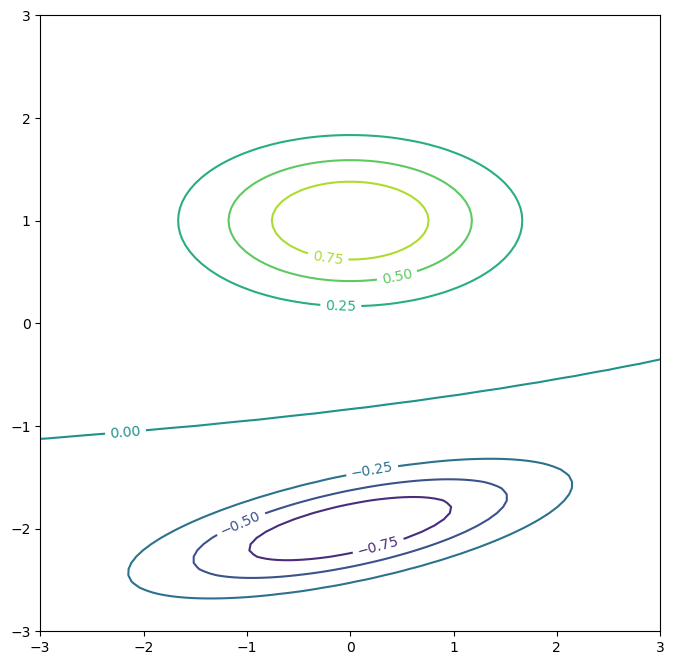

In [37]:
fig, ax = plt.subplots(figsize=(8, 8))
plot_function(f, ax)

We will now try to minimize $f$ using gradient descent, with optional flavors. For this, we define a minimize function that performs gradient descent, along with a helper class `GradientDescent` that will perform the updates given the gradient

In [38]:
class GradientDescent:
    
    def __init__(self, params, lr=0.1):
        self.params = params
        self.lr = lr

    def step(self):
        with torch.no_grad():
            for param in self.params:
                param -= self.lr * param.grad

    def zero_grad(self):
        for param in self.params:
            if param.grad is not None:
                param.grad.zero_()

In [39]:
def minimize(f, optimizer, max_iter=500, verbose=False):
    if hasattr(optimizer, 'params'):
        [iterate] = optimizer.params
    else:
        # For pytorch optimizers.
        assert len(optimizer.param_groups) == 1
        [iterate] = optimizer.param_groups[0]['params']
    iterate_record = []

    for i in range(max_iter):
        # iterate.grad may be non zero. We zero it first:
        optimizer.zero_grad()
        value = f(iterate)
        
        # Compute the gradient of f with respect to the parameters:
        value.backward()
        # iterate.grad now holds $\nabla_x f(x)$
        if float(torch.sum(iterate.grad ** 2)) < 1e-6:
            if verbose:
                print('Converged at iteration %i: '
                      'f(x) = %e, x = [%e, %e]'
                      % (i, value, iterate[0], iterate[1]))
            break
        
        # We store the trajectory of the iterates
        iterate_record.append(iterate.data.clone()[None, :])
        if verbose and i % 10 == 0:
            print('Iteration %i: f(x) = %e, x = [%e, %e]'
                  % (i, value, iterate[0], iterate[1]))

        # Perform the parameter update step using the gradient
        # values:
        optimizer.step()
    return torch.cat(iterate_record, dim=0)

Run the minimization algorithm and plot it:

In [40]:
# The extra dimension marked with `None` is used to make it 
# possible
init = torch.tensor([0.8, 0.8], dtype=torch.float32)
optimizer = GradientDescent([init.clone().requires_grad_()], lr=0.1)
iterate_rec = minimize(f, optimizer, verbose=True)

Iteration 0: f(x) = 6.703200e-01, x = [8.000000e-01, 8.000000e-01]
Iteration 10: f(x) = 1.289651e-01, x = [1.167153e+00, 1.732319e-01]
Iteration 20: f(x) = 3.870839e-02, x = [1.257323e+00, -1.093341e-01]
Iteration 30: f(x) = 1.977912e-02, x = [1.293544e+00, -2.421951e-01]
Iteration 40: f(x) = 1.257435e-02, x = [1.314545e+00, -3.247409e-01]
Iteration 50: f(x) = 8.920575e-03, x = [1.328896e+00, -3.836930e-01]
Iteration 60: f(x) = 6.725642e-03, x = [1.339650e+00, -4.294602e-01]
Iteration 70: f(x) = 5.242490e-03, x = [1.348210e+00, -4.671288e-01]
Iteration 80: f(x) = 4.143619e-03, x = [1.355332e+00, -4.995898e-01]
Iteration 90: f(x) = 3.262446e-03, x = [1.361466e+00, -5.286921e-01]
Iteration 100: f(x) = 2.502143e-03, x = [1.366915e+00, -5.557572e-01]
Iteration 110: f(x) = 1.796959e-03, x = [1.371894e+00, -5.818535e-01]
Iteration 120: f(x) = 1.091564e-03, x = [1.376583e+00, -6.079812e-01]
Iteration 130: f(x) = 3.244226e-04, x = [1.381148e+00, -6.352491e-01]
Iteration 140: f(x) = -5.959946e-

In [41]:
def plot_trace(iterate_rec, ax, label='', tags=True):
    iterate_rec = iterate_rec.numpy()
    n_steps = len(iterate_rec)
    line = ax.plot(iterate_rec[:, 0], iterate_rec[:, 1], linestyle=':',
                   marker='o', markersize=2,
                   label=label + " (%d steps)" % n_steps)
    color = plt.getp(line[0], 'color')
    bbox_props = dict(boxstyle="square,pad=0.3", ec=color, fc='white',
                      lw=1)
    if tags:
        # Put tags every 10 iterates. The small randomization makes it
        # easier to spot tag overlap when the steps are very small.
        for i in range(0, len(iterate_rec), 10):
            ax.annotate(i, xy=(iterate_rec[i, 0], iterate_rec[i, 1]),
                        xycoords='data',
                        xytext=(5 + np.random.uniform(-2, 2),
                                5 + np.random.uniform(-2, 2)),
                        textcoords='offset points',
                        bbox=bbox_props)

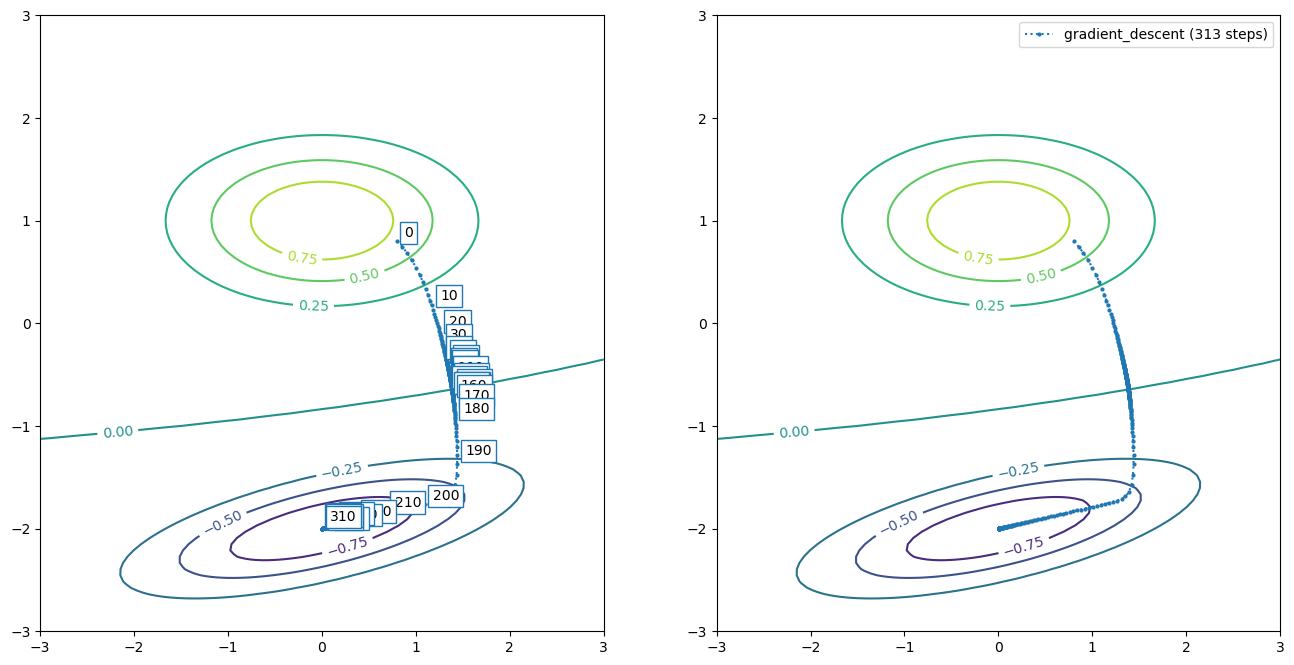

In [42]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 8))
plot_function(f, ax1)
plot_function(f, ax2)
plot_trace(iterate_rec, ax1, label='gradient_descent')
plot_trace(iterate_rec, ax2, label='gradient_descent', tags=False)
plt.legend();

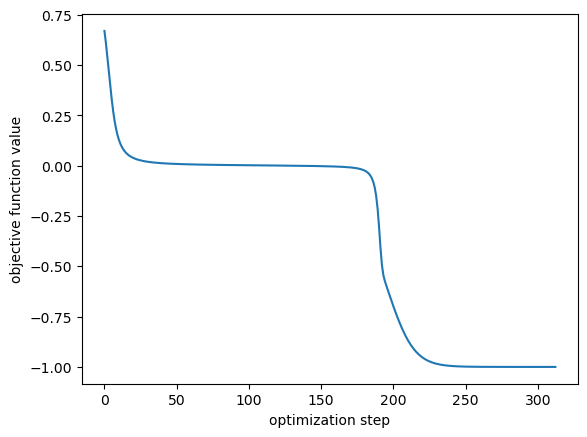

In [43]:
plt.plot([f(x).numpy() for x in iterate_rec])
plt.xlabel('optimization step')
plt.ylabel('objective function value');

## Exercices

- Try to move the initialization point to the other side of the yellow mountain, for instance at position `[0.8, 1.2]`. What do you observe? How to do you explain this?

- Put back the init to `[0.8, 0.8]` and implement the step method of `MomemtumGradientDescent` in the following cell,
- Check that it behaves as `GradientDescent` for `momemtum=0`
- Can you find a value of `momentum` that makes it converge faster than gradient descent on for this objective function? Try with different values of `lr` and `momentum`.
- Try to use [torch.optim.Adam](http://pytorch.org/docs/master/optim.html#torch.optim.Adam) in the minimization loop.
- Compare the three trajectories.


For the momentum let's use the following 2-stage mathematical description of the update step:

$$ \mathbf{v} \leftarrow \mu \cdot \mathbf{v} + \nabla_\mathbf{x}\ell(\mathbf{x}) $$
$$ \mathbf{x} \leftarrow \eta \cdot \mathbf{v} $$

where:

- $\eta$ is the learning rate coefficient (`lr` in Python code);
- $\mu$ is the momentum coefficient (set to 0.9 by default);
- $\nabla_\mathbf{x}\ell(\mathbf{x})$ is the gradient of the loss function for the current value of the parameters $\mathbf{x}$;
- $\mathbf{v}$ is the tensor of velocities and as the same shape as the parameters tensor $\theta$. $v$ is initialized to zero.

In [44]:
class MomentumGradientDescent(GradientDescent):

    def __init__(self, params, lr=0.1, momentum=.9):
        super(MomentumGradientDescent, self).__init__(params, lr)
        self.momentum = momentum
        self.velocities = [torch.zeros_like(param, requires_grad=False)
                           for param in params]

    def step(self):
        # TODO: implement me!
        pass

In [45]:
# %load solutions/momentum_optimizer.py
class MomentumGradientDescent(GradientDescent):

    def __init__(self, params, lr=0.1, momentum=.9):
        super(MomentumGradientDescent, self).__init__(params, lr)
        self.momentum = momentum
        self.velocities = [torch.zeros_like(param, requires_grad=False)
                           for param in params]

    def step(self):
        with torch.no_grad():
            for i, (param, velocity) in enumerate(zip(self.params,
                                                      self.velocities)):
                velocity = self.momentum * velocity + param.grad
                param -= self.lr * velocity
                self.velocities[i] = velocity


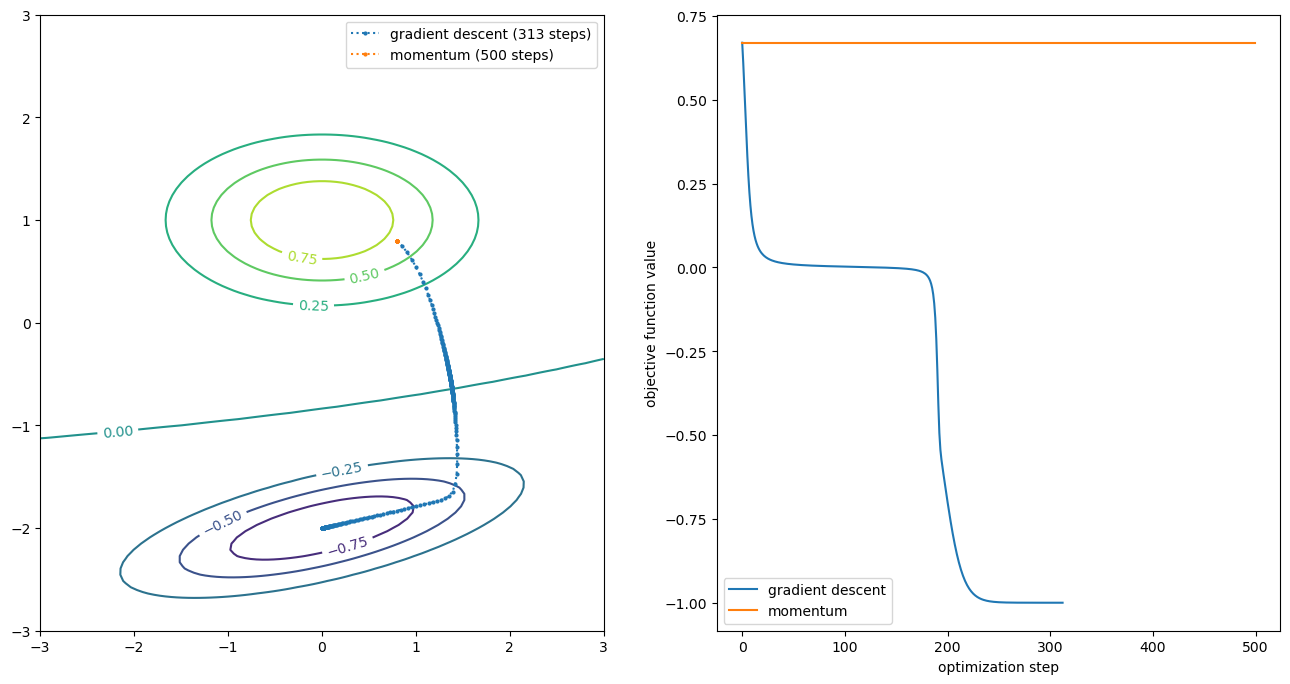

In [46]:
lr = 0.1
init = torch.FloatTensor([0.8, 0.8])
optimizer = GradientDescent([init.clone().requires_grad_()], lr=lr)
iterate_rec_gd = minimize(f, optimizer)

optimizer = MomentumGradientDescent([init.clone().requires_grad_()],
                                    lr=lr, momentum=0.9)
iterate_rec_mom = minimize(f, optimizer)


fig, (ax0, ax1) = plt.subplots(ncols=2, figsize=(16, 8))
plot_function(f, ax0)
plot_trace(iterate_rec_gd, ax0, label='gradient descent', tags=False)
plot_trace(iterate_rec_mom, ax0, label='momentum', tags=False)
ax0.legend();

ax1.plot([f(x).numpy() for x in iterate_rec_gd], label='gradient descent')
ax1.plot([f(x).numpy() for x in iterate_rec_mom], label='momentum')
ax1.set_xlabel('optimization step')
ax1.set_ylabel('objective function value')
ax1.legend();

What do you observe ? Try changing the momentum and the initialization to compare optimization traces.